In [ ]:
import os
import zipfile
from PIL import Image
import numpy as np

# Step 1: Unzip dataset

with zipfile.ZipFile("road_detection_datasetV2.zip", 'r') as zip_ref:
    zip_ref.extractall('dataset_content')

# we had a problem of so lables was empty but their images exicte so we delete them (matching pair )

In [ ]:
import os

# ✅ Set your dataset root
base_path = "dataset_content"
splits = ["train", "valid", "test"]
image_exts = [".jpg", ".png"]

deleted_count = 0
skipped_count = 0

for split in splits:
    labels_dir = os.path.join(base_path, split, "labels")
    images_dir = os.path.join(base_path, split, "images")

    if not os.path.exists(labels_dir) or not os.path.exists(images_dir):
        print(f"⚠️ Skipping {split} — missing labels or images folder.")
        continue

    for fname in os.listdir(labels_dir):
        if not fname.endswith(".txt"):
            continue

        label_path = os.path.join(labels_dir, fname)

        # Check if label file is empty or contains only blank lines
        with open(label_path, "r") as f:
            lines = [ln.strip() for ln in f.readlines()]
        if len(lines) == 0 or all(ln == "" for ln in lines):
            # Delete label file
            os.remove(label_path)

            # Try to delete corresponding image
            base_name = os.path.splitext(fname)[0]
            deleted_image = False
            for ext in image_exts:
                img_path = os.path.join(images_dir, base_name + ext)
                if os.path.exists(img_path):
                    os.remove(img_path)
                    deleted_image = True
                    break

            deleted_count += 1
            print(f"🗑️ Deleted empty label and image: {fname}")
        else:
            skipped_count += 1

print(f"\n✅ Cleanup complete.")
print(f"🗑️ Deleted {deleted_count} empty label-image pairs.")
print(f"✅ Kept {skipped_count} valid label files.")


✅ Cleanup complete.
🗑️ Deleted 0 empty label-image pairs.
✅ Kept 764 valid label files.


# we had a prolem here that some lables were not in the yolo format (in the Polygon format ) and this was the error


In [ ]:
import os
from PIL import Image

# ✅ Step 1: Define your class mapping
class_map = {
    0: 'bicycles',
    1: 'buses',
    2: 'crosswalks',
    3: 'fire hydrants',
    4: 'motorcycles',
    5: 'traffic lights',
    6: 'vehicles'
}

# ✅ Step 2: Set paths
base_path = "dataset_content"   # Folder where your YOLO dataset is stored
output_root = "cropped_objectsV3" # Output folder for cropped images
os.makedirs(output_root, exist_ok=True)

# ✅ Step 3: Loop through each split
for split in ["train", "valid", "test"]:
    images_dir = os.path.join(base_path, split, "images")
    labels_dir = os.path.join(base_path, split, "labels")

    if not os.path.exists(images_dir) or not os.path.exists(labels_dir):
        print(f"⚠️ Skipping {split} — missing images or labels folder.")
        continue

    print(f"🔄 Processing {split}...")

    for fname in os.listdir(images_dir):
        if not (fname.endswith(".jpg") or fname.endswith(".png")):
            continue

        img_path = os.path.join(images_dir, fname)
        label_path = os.path.join(labels_dir, os.path.splitext(fname)[0] + ".txt")

        if not os.path.exists(label_path):
            print(f"⚠️ Label missing for {fname}, skipping.")
            continue

        # Load image
        try:
            img = Image.open(img_path)
            img_w, img_h = img.size
        except Exception as e:
            print(f"❌ Failed to open image {img_path}: {e}")
            continue

        # Load label
        with open(label_path, 'r') as f:
            lines = [ln.strip() for ln in f.readlines() if ln.strip()]

        if len(lines) == 0:
            print(f"⚠️ Empty label file for {fname}, skipping.")
            continue

        for i, line in enumerate(lines):
            parts = line.strip().split()
            class_id = int(parts[0])

            #  Case 1: Standard YOLO bbox format (5 values)
            if len(parts) == 5:
                try:
                    x_c, y_c, w, h = map(float, parts[1:])
                except Exception as e:
                    print(f"⚠️ Parse error in {label_path} at line {i+1}: {line} ({e})")
                    continue

                x1 = int((x_c - w / 2) * img_w)
                y1 = int((y_c - h / 2) * img_h)
                x2 = int((x_c + w / 2) * img_w)
                y2 = int((y_c + h / 2) * img_h)

            #  Case 2: Polygon format (>5 values)
            elif len(parts) > 5:
                try:
                    coords = list(map(float, parts[1:]))
                    points = [(coords[j], coords[j+1]) for j in range(0, len(coords), 2)]
                    xs = [p[0] for p in points]
                    ys = [p[1] for p in points]

                    x_min, x_max = min(xs), max(xs)
                    y_min, y_max = min(ys), max(ys)

                    x1 = int(x_min * img_w)
                    y1 = int(y_min * img_h)
                    x2 = int(x_max * img_w)
                    y2 = int(y_max * img_h)
                except Exception as e:
                    print(f"⚠️ Polygon parse error in {label_path} at line {i+1}: {line} ({e})")
                    continue

            else:
                print(f"⚠️ Malformed label in {label_path} at line {i+1}: {line}")
                continue

            # ✅ Clip to image bounds
            x1 = max(0, min(x1, img_w - 1))
            y1 = max(0, min(y1, img_h - 1))
            x2 = max(0, min(x2, img_w))
            y2 = max(0, min(y2, img_h))

            if x2 <= x1 or y2 <= y1:
                print(f"⚠️ Invalid box in {label_path} at line {i+1}, skipping.")
                continue

            # ✅ Crop and resize
            cropped = img.crop((x1, y1, x2, y2)).resize((64, 64)).convert('L')

            # ✅ Get class name
            label_name = class_map.get(class_id, f"class{class_id}")

            # ✅ Save to split/class folder
            class_dir = os.path.join(output_root, split, label_name)
            os.makedirs(class_dir, exist_ok=True)

            save_name = f"{split}_{os.path.splitext(fname)[0]}_obj{i}_{label_name}.png"
            cropped.save(os.path.join(class_dir, save_name))

print("✅ All objects cropped and saved by split and class.")


🔄 Processing train...
🔄 Processing valid...
🔄 Processing test...
✅ All objects cropped and saved by split and class.


 # so now based on this we can say that we have two dataset one for the basic ML and one for the neurall network using the yolo format

# 1.visualization for Basic ML Dataset (cropped images)
- 1 Bar chart: number of images per class (bicycles, buses, etc.)

- 2  Sample grid: show a few cropped images per clas


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image, ImageDraw





# 1\   Bar chart: number of images per class (bicycles, buses, etc.)

In [ ]:

def count_basicml_images(root):
    rows = []
    for split in ["train", "valid", "test"]:
        split_dir = os.path.join(root, split)
        if not os.path.exists(split_dir): continue
        for cls in os.listdir(split_dir):
            cls_dir = os.path.join(split_dir, cls)
            if not os.path.isdir(cls_dir): continue
            count = len([f for f in os.listdir(cls_dir) if f.endswith(".png")])
            rows.append({"split": split, "class": cls, "count": count})
    return pd.DataFrame(rows)

df_basic = count_basicml_images("cropped_objectsV3")


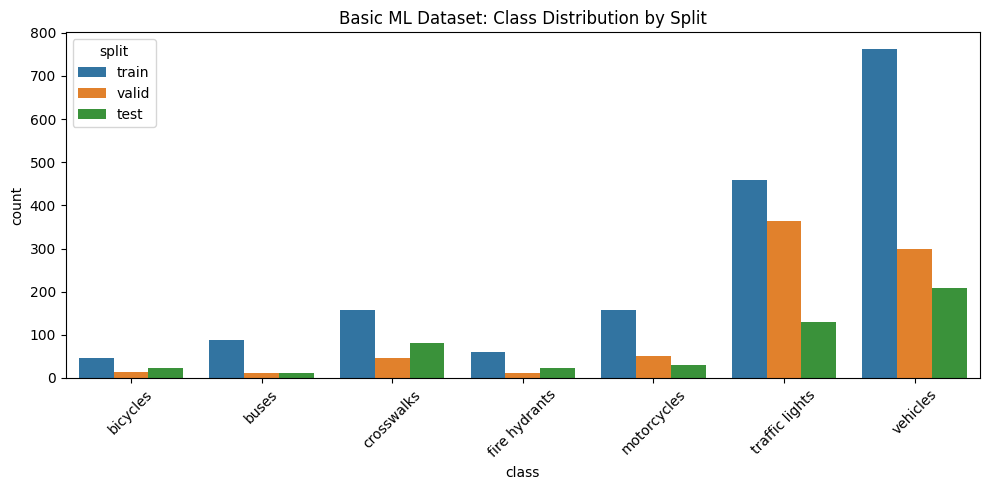

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(data=df_basic, x="class", y="count", hue="split")
plt.xticks(rotation=45)
plt.title("Basic ML Dataset: Class Distribution by Split")
plt.tight_layout()
plt.show()


 #  Sample grid: show a few cropped images per clas

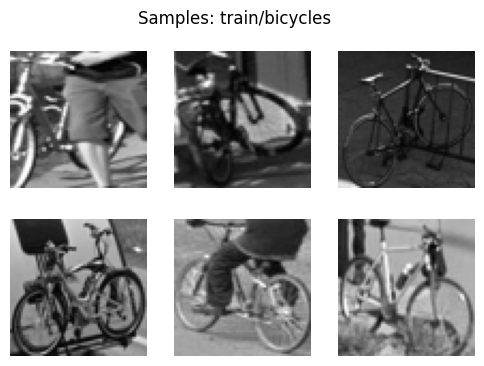

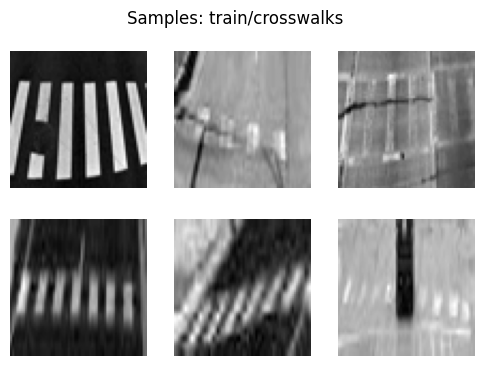

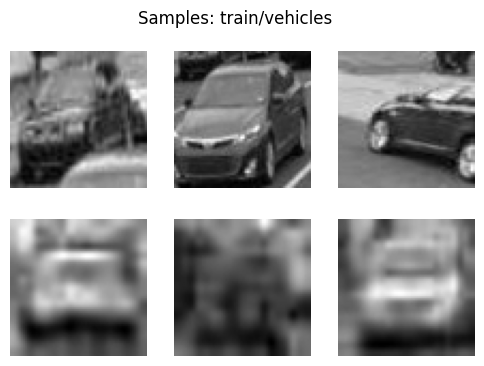

In [ ]:
def show_samples(root, split, cls, n=9):
    cls_dir = os.path.join(root, split, cls)
    files = [f for f in os.listdir(cls_dir) if f.endswith(".png")][:n]
    imgs = [Image.open(os.path.join(cls_dir, f)) for f in files]
    cols = 3; rows = (len(imgs)+2)//3
    plt.figure(figsize=(cols*2, rows*2))
    for i, im in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(im, cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Samples: {split}/{cls}")
    plt.show()

show_samples('cropped_objectsV3', "train", "bicycles", n=6)
show_samples('cropped_objectsV3', "train", "crosswalks", n=6)
show_samples('cropped_objectsV3', "train", "vehicles", n=6)


# 2. YOLO Dataset (neural network)
-  Histogram: bounding box area distribution (normalized)
-  Heatmap: bounding box center positions
-  Bar chart: number of objects per class across splits
-  Preview images: original images with bounding boxes draw


In [ ]:
def parse_yolo_labels(labels_dir, img_w, img_h):
    areas, centers, classes = [], [], []
    for fname in os.listdir(labels_dir):
        if not fname.endswith(".txt"): continue
        with open(os.path.join(labels_dir, fname)) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    cid = int(parts[0])
                    cx, cy, bw, bh = map(float, parts[1:])
                    areas.append(bw*bh)
                    centers.append((cx, cy))
                    classes.append(cid)
                elif len(parts) > 5:
                    # polygon → bounding box
                    coords = list(map(float, parts[1:]))
                    xs = coords[0::2]; ys = coords[1::2]
                    bw = max(xs)-min(xs); bh = max(ys)-min(ys)
                    cx = (max(xs)+min(xs))/2; cy = (max(ys)+min(ys))/2
                    areas.append(bw*bh)
                    centers.append((cx, cy))
                    classes.append(int(parts[0]))
    return areas, centers, classes


In [ ]:
img_sample = Image.open(os.path.join('dataset_content',"train/images",os.listdir(os.path.join('dataset_content',"train/images"))[0]))
img_w, img_h = img_sample.size
areas, centers, classes = parse_yolo_labels(os.path.join('dataset_content',"train/labels"), img_w, img_h)


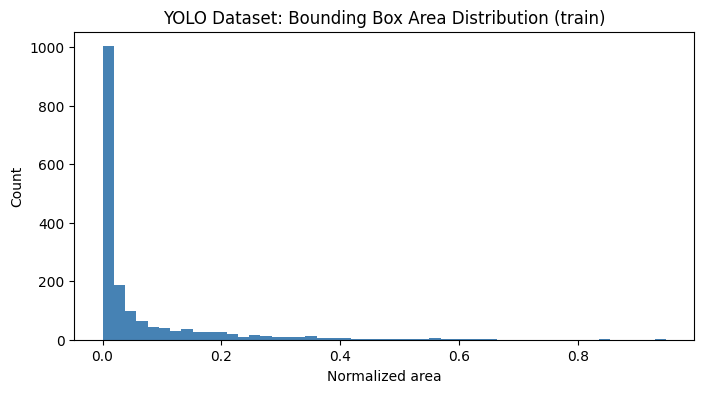

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(areas, bins=50, color="steelblue")
plt.title("YOLO Dataset: Bounding Box Area Distribution (train)")
plt.xlabel("Normalized area")
plt.ylabel("Count")
plt.show()



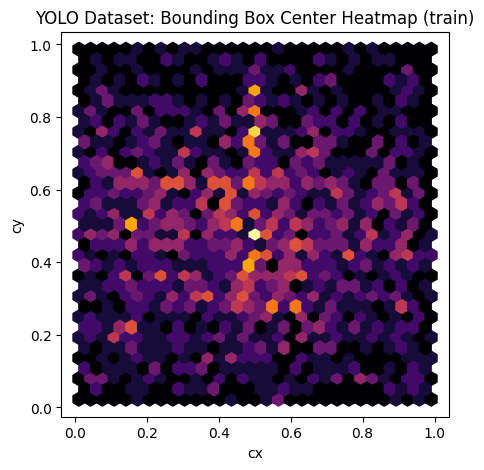

In [ ]:
cx, cy = zip(*centers)
plt.figure(figsize=(5,5))
plt.hexbin(cx, cy, gridsize=30, cmap="inferno")
plt.title("YOLO Dataset: Bounding Box Center Heatmap (train)")
plt.xlabel("cx")
plt.ylabel("cy")
plt.show()
